# Bounding Bosの可視化

In [24]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from ssd import build_ssd
from data import VISAPP_ROOT, AnnotationTransform, VISAPP2020_Detection, BaseTransform
from data import VISAPP2020_CLASSES as labelmap
import torch.utils.data as data

from ssd import build_ssd
import sys
import os
import time
import argparse
import numpy as np
import pickle
import cv2
import json
%matplotlib inline
from matplotlib import pyplot as plt

set_type = "test"
devkit_path = VISAPP_ROOT
dataset_mean = (104, 117, 123)

## SSDのビルド

In [25]:
num_classes = len(labelmap) + 1 
net = build_ssd('test', 300, num_classes)    # initialize SSD
#net.load_weights('../weights/ssd300_mAP_77.43_v2.pth')
net.load_weights("weights/VISAPP.pth")

Loading weights into state dict...
Finished!


/home/akizuki/VISAPP2020/ObjectDetection/ssd.pytorch/ssd.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors = Variable(self.priorbox.forward(), volatile=True)


In [26]:
dataset = VISAPP2020_Detection(VISAPP_ROOT, set_type,
                           BaseTransform(300, dataset_mean),
                           AnnotationTransform())

556
549
556
580
551
549
533
532
561
550
558
543
551
553
576
540
564
543
530
561


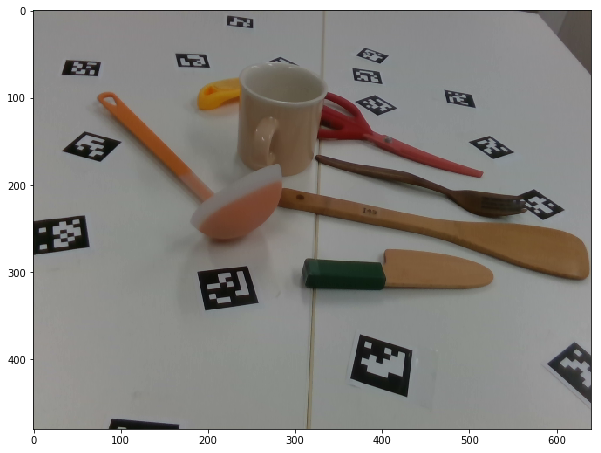

In [42]:
img_id = 5000
image = dataset.pull_image(img_id)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

## Pre-process the input.  
#### Using the torchvision package, we can create a Compose of multiple built-in transorm ops to apply 
For SSD, at test time we use a custom BaseTransform callable to
resize our image to 300x300, subtract the dataset's mean rgb values, 
and swap the color channels for input to SSD300.

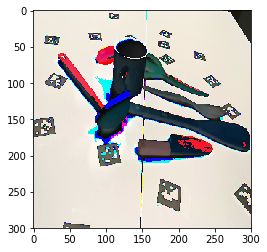

In [43]:
x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
plt.imshow(x)
x = torch.from_numpy(x).permute(2, 0, 1)

In [44]:
xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()
y = net(xx)

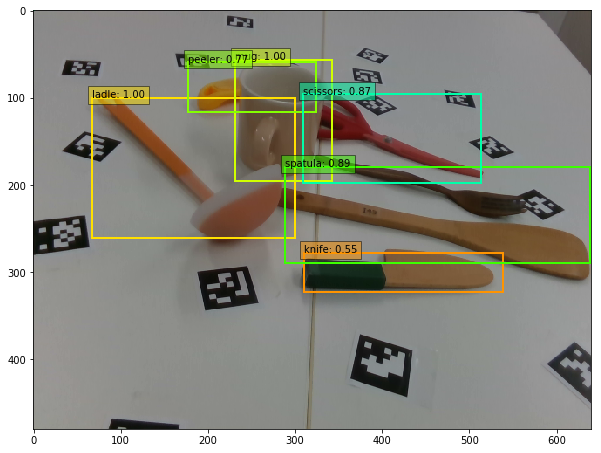

In [47]:
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.5:
        score = detections[0,i,j,0]
        label_name = labelmap[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1
        
plt.savefig("out.png")